In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
%matplotlib inline

# Отключить все предупреждения
warnings.filterwarnings('ignore')

0
[0 1]
99.0
8707.0
order_status                        0
total_order_items                   0
tot_unique_items                    0
cost(USD)                           0
vendor_id                           0
payment_type                        0
vendor_client_distance              0
estimated_delivery_time             0
predicted_order_preparation_time    0
dtype: int64
test
order_status                        0
total_order_items                   0
tot_unique_items                    0
cost(USD)                           0
vendor_id                           0
payment_type                        0
vendor_client_distance              0
estimated_delivery_time             0
predicted_order_preparation_time    0
dtype: int64
1177 185812
183751 356495


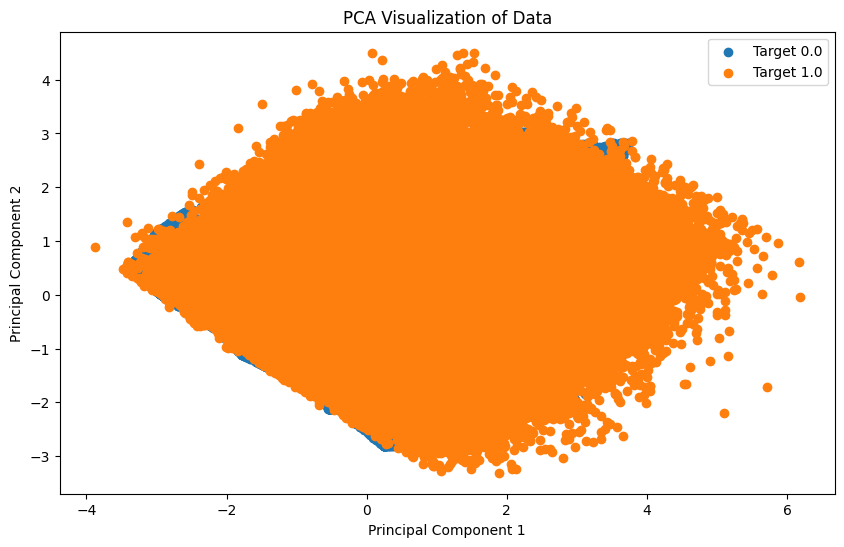


LogisticRegression with L1
Train accuracy = 0.579177828581046
Train precision = 0.578244550807479
Train recall = 0.4860602973185755
Testing accuracy = 0.5494918173987942
Testing precision = 0.8837224176527023
Testing recall = 0.5510269192422732

LogisticRegression with L2
Train accuracy = 0.5791666082273244
Train precision = 0.5782350875018079
Train recall = 0.4860255638401334
Testing accuracy = 0.549526270456503
Testing precision = 0.8837789433286427
Testing recall = 0.5510269192422732


In [6]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = False)

# remove outliers from train
train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
#check if tot_unique_items > total_order_items -> it's none
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

#CHECK
print("estimated_delivery_time")
print(train["estimated_delivery_time"].max())
q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
print(train["estimated_delivery_time"].max())
print("vendor_client_distance")
print(train["vendor_client_distance"].max())
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]
print(train["vendor_client_distance"].max())

#impute
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean')
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)
    
#impute with outliers

print(train.isna().sum())
print("test")
print(test.isna().sum())

train.drop(['vendor_id'], axis = 1, inplace=True)
test.drop(['vendor_id'], axis = 1, inplace=True)
train.drop(['tot_unique_items'], axis = 1, inplace=True)
test.drop(['tot_unique_items'], axis = 1, inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create StandardScaler instance
scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

#with outliers scaling RobustScaler()

#balance
print(len(y_train.loc[y_train == 0]), len(y_train))
smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)
print(len(y_train.loc[y_train == 0]), len(y_train))


# Create subplots for each feature
# for column in X_train.columns:
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X_train[column], y_train, c='blue')
#     plt.xlabel(column)
#     plt.ylabel('Predictions')
#     plt.title(f'Scatterplot of {column} vs. Predictions')
#     plt.show()

#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()


# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))



In [11]:
#Create an SVM classifier (linear kernel)
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

y_pred_train = svm_classifier.predict(X_train)
y_pred_test = svm_classifier.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred_test)
print("\n SVM")
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print("Testing accuracy = {}:".format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

KeyboardInterrupt: 

In [10]:
# Create a Lasso model
lasso = Lasso(alpha=0.001)
# Fit the Lasso model on the training data
lasso.fit(X_train, y_train)
# Get the feature importances or coefficients
feature_importances = lasso.coef_
print(feature_importances)
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

[ 0.04675544  0.02248313  0.16036281  0.01518334  0.00065525 -0.02561513]
[('payment_type', 0.16036281064760546), ('total_order_items', 0.04675544493881987), ('predicted_order_preparation_time', -0.025615130865871773), ('cost(USD)', 0.02248313382647034), ('vendor_client_distance', 0.015183343983800618), ('estimated_delivery_time', 0.0006552521982458991)]


0
[('total_order_items', 0.010688371152752597), ('tot_unique_items', -0.002047563042241895), ('payment_type', -0.0016703675392512368), ('predicted_order_preparation_time', -0.00026971165594477734), ('cost(USD)', 0.00016166185064587726), ('estimated_delivery_time', -5.3282432631956765e-05), ('vendor_id', -9.721306991165777e-06), ('vendor_client_distance', -2.9983479226137365e-06)]


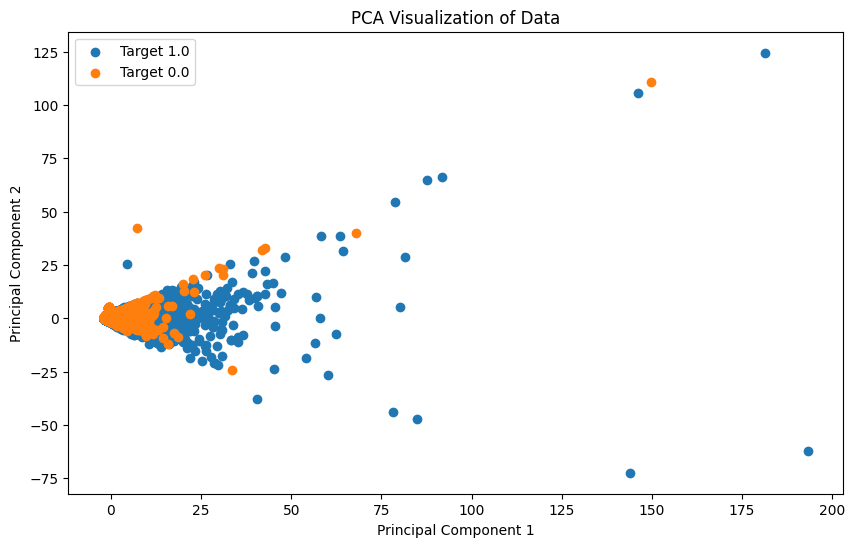


LogisticRegression with L1
Train accuracy = 0.8713067246514405
Train precision = 0.8712975158513799
Train recall = 0.999986816953398
Testing accuracy = 0.8722825150732127
Testing precision = 0.8723081693829032
Testing recall = 0.9999605024093531
Confusion Matrix:
 [[    1  3706]
 [    1 25317]]

LogisticRegression with L2
Train accuracy = 0.8713067246514405
Train precision = 0.8712975158513799
Train recall = 0.999986816953398
Testing accuracy = 0.8722825150732127
Testing precision = 0.8723081693829032
Testing recall = 0.9999605024093531
Confusion Matrix:
 [[    1  3706]
 [    1 25317]]


In [ ]:
#without remove outliers and balancing and not depend on order_created time

df = pd.read_json('order_cancellation_data.json')

#df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = True)

#impute
#test = test.fillna(train.mean())
#train = train.fillna(train.mean())
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean')
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

#train.drop(['vendor_id'], axis = 1, inplace=True)
#test.drop(['vendor_id'], axis = 1, inplace=True)
# train.drop(['tot_unique_items'], axis = 1, inplace=True)
# test.drop(['tot_unique_items'], axis = 1, inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

#feature selection
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
feature_importances = lasso.coef_
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create RobustScaler instance
scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()


# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

y_pred_train = svm_classifier.predict(X_train)
y_pred_test = svm_classifier.predict(X_test)

# confusion_mat = confusion_matrix(y_test, y_pred_test)
# print("\n SVM")
# print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
# print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
# print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
# print("Testing accuracy = {}:".format(metrics.accuracy_score(y_test, y_pred_test)))
# print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
# print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
# print("Confusion Matrix:\n", confusion_mat)

0
[('total_order_items', 0.010248993400864664), ('payment_type', -0.0024601396164804943), ('tot_unique_items', -0.0013718401294962744), ('predicted_order_preparation_time', -0.0003723963665687729), ('cost(USD)', 0.00019058899383892782), ('estimated_delivery_time', -1.2432622589692792e-05), ('vendor_id', -9.628939839720953e-06), ('vendor_client_distance', -3.158827594933669e-06)]


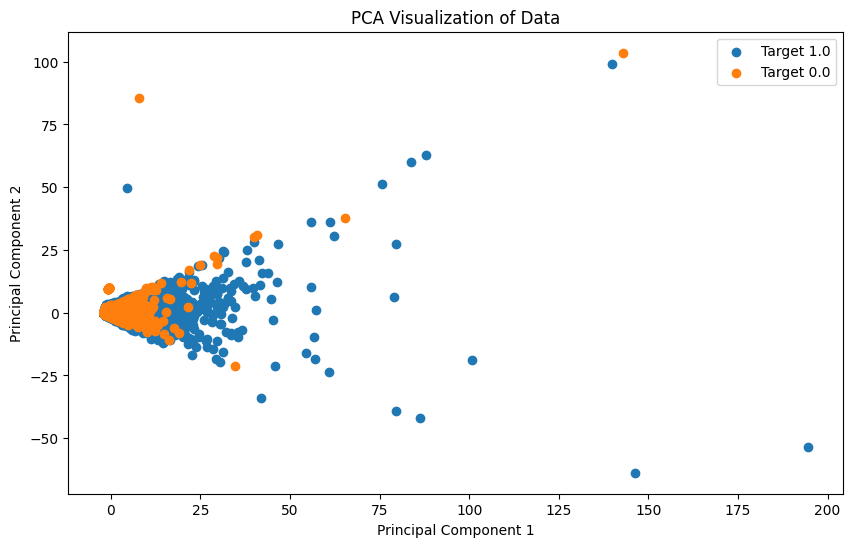

33410 261218
227808 455616

LogisticRegression with L1
Train accuracy = 0.5802298426745329
Train precision = 0.5912772927945025
Train recall = 0.5197139696586599
Testing accuracy = 0.5374332472006891
Testing precision = 0.8974411463664278
Testing recall = 0.524506480558325
Confusion Matrix:
 [[ 2447  1503]
 [11923 13152]]

LogisticRegression with L2
Train accuracy = 0.5801947253827785
Train precision = 0.5912182066926972
Train recall = 0.5197710352577609
Testing accuracy = 0.5375021533161068
Testing precision = 0.8974551408883128
Testing recall = 0.5245862412761715
Confusion Matrix:
 [[ 2447  1503]
 [11921 13154]]


In [4]:
#without remove outliers and depend on order_created time , BALANCE OverSampling

df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = False)

#impute
#test = test.fillna(train.mean())
#train = train.fillna(train.mean())
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean')
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

#train.drop(['vendor_id'], axis = 1, inplace=True)
#test.drop(['vendor_id'], axis = 1, inplace=True)
# train.drop(['tot_unique_items'], axis = 1, inplace=True)
# test.drop(['tot_unique_items'], axis = 1, inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

#feature selection
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
feature_importances = lasso.coef_
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create RobustScaler instance
scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

#balance
print(len(y_train.loc[y_train == 0]), len(y_train))
over_sampl = RandomOverSampler(random_state=0)
X_train, y_train = over_sampl.fit_resample(X_train, y_train)
print(len(y_train.loc[y_train == 0]), len(y_train))

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(X_train, y_train)

# y_pred_train = svm_classifier.predict(X_train)
# y_pred_test = svm_classifier.predict(X_test)

# confusion_mat = confusion_matrix(y_test, y_pred_test)
# print("\n SVM")
# print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
# print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
# print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
# print("Testing accuracy = {}:".format(metrics.accuracy_score(y_test, y_pred_test)))
# print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
# print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
# print("Confusion Matrix:\n", confusion_mat)

0
[('total_order_items', 0.01030578640591071), ('payment_type', -0.0017617503311997353), ('tot_unique_items', -0.0014384493866777337), ('predicted_order_preparation_time', -0.0003864636113492498), ('cost(USD)', 0.00019934472247070897), ('estimated_delivery_time', -3.517093063515996e-05), ('vendor_id', -9.630753204565385e-06), ('vendor_client_distance', -3.0336250960773723e-06)]


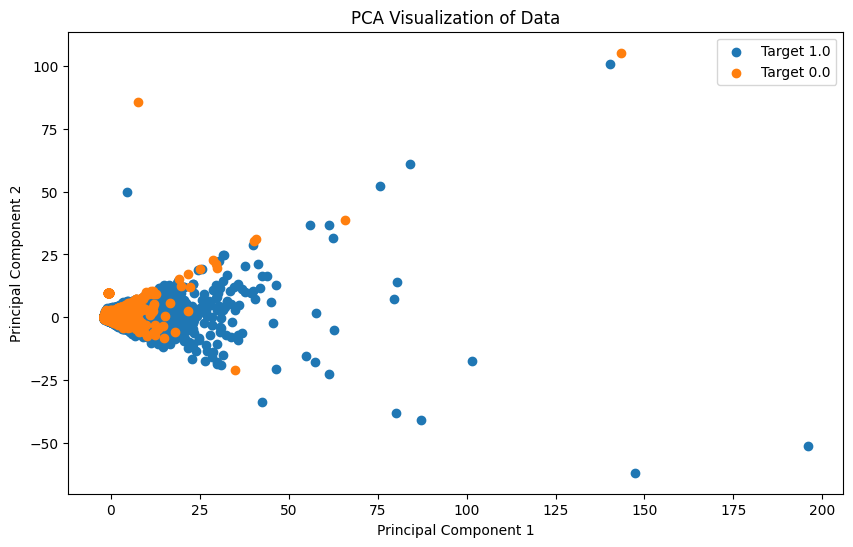

33530 261218
33530 67060

LogisticRegression with L1
Train accuracy = 0.5791977333730988
Train precision = 0.5899285448203461
Train recall = 0.5195347450044736
Testing accuracy = 0.5323686477174849
Testing precision = 0.9015339966832504
Testing recall = 0.517840841436793
Confusion Matrix:
 [[ 2405  1425]
 [12148 13047]]

LogisticRegression with L2
Train accuracy = 0.5793468535639725
Train precision = 0.5900795666158795
Train recall = 0.5197733373098717
Testing accuracy = 0.5324720068906116
Testing precision = 0.9015544041450777
Testing recall = 0.5179599126810875
Confusion Matrix:
 [[ 2405  1425]
 [12145 13050]]


In [6]:
#without remove outliers and not depend on order_created time , BALANCE UnderSAMPLING

df = pd.read_json('order_cancellation_data.json')

#df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = True)

#impute
#test = test.fillna(train.mean())
#train = train.fillna(train.mean())
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean')
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

#train.drop(['vendor_id'], axis = 1, inplace=True)
#test.drop(['vendor_id'], axis = 1, inplace=True)
# train.drop(['tot_unique_items'], axis = 1, inplace=True)
# test.drop(['tot_unique_items'], axis = 1, inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

#feature selection
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
feature_importances = lasso.coef_
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create RobustScaler instance
scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

#balance
print(len(y_train.loc[y_train == 0]), len(y_train))
uper_sampl = RandomUnderSampler(random_state=0)
X_train, y_train = uper_sampl.fit_resample(X_train, y_train)
print(len(y_train.loc[y_train == 0]), len(y_train))

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(X_train, y_train)

# y_pred_train = svm_classifier.predict(X_train)
# y_pred_test = svm_classifier.predict(X_test)

# confusion_mat = confusion_matrix(y_test, y_pred_test)
# print("\n SVM")
# print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
# print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
# print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
# print("Testing accuracy = {}:".format(metrics.accuracy_score(y_test, y_pred_test)))
# print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
# print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
# print("Confusion Matrix:\n", confusion_mat)

0
[('total_order_items', 0.010296634526935923), ('payment_type', -0.0019106711080183747), ('tot_unique_items', -0.0016763331056421603), ('predicted_order_preparation_time', -0.0003458220131606436), ('cost(USD)', 0.00018518422569066933), ('estimated_delivery_time', -1.5461118346002435e-05), ('vendor_id', -9.656190697282862e-06), ('vendor_client_distance', -3.1770761747932423e-06)]


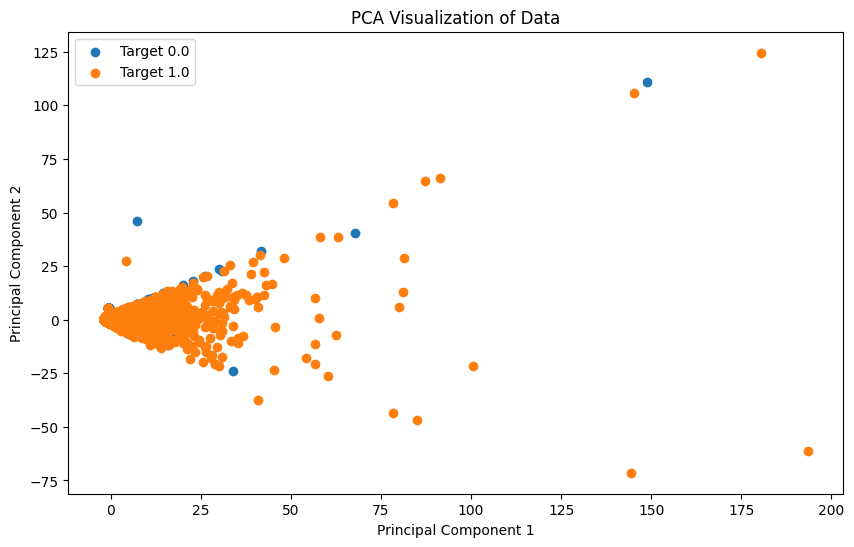

33527 261218
209503 381400

LogisticRegression with L1
Train accuracy = 0.6069244887257472
Train precision = 0.6063033257879157
Train recall = 0.36461369308364894
Testing accuracy = 0.40172265288544357
Testing precision = 0.9146095984744147
Testing recall = 0.3426881549698317
Confusion Matrix:
 [[ 3027   806]
 [16559  8633]]

LogisticRegression with L2
Train accuracy = 0.6069166229680126
Train precision = 0.6062960132343979
Train recall = 0.3645846058977178
Testing accuracy = 0.40175710594315245
Testing precision = 0.9147065056155965
Testing recall = 0.3426881549698317
Confusion Matrix:
 [[ 3028   805]
 [16559  8633]]


In [5]:
#without remove outliers and not depend on order_created time , BALANCE SMOTEENN

df = pd.read_json('order_cancellation_data.json')

#df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = True)

#impute
#test = test.fillna(train.mean())
#train = train.fillna(train.mean())
columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
for column in columns_to_impute:
    mean_col = train.groupby('vendor_id')[column].transform('mean')
    train[column].fillna(mean_col, inplace=True)
    train[column].fillna(mean_col.mean(), inplace=True)
    test[column].fillna(mean_col, inplace=True)
    test[column].fillna(mean_col.mean(), inplace=True)

#train.drop(['vendor_id'], axis = 1, inplace=True)
#test.drop(['vendor_id'], axis = 1, inplace=True)
# train.drop(['tot_unique_items'], axis = 1, inplace=True)
# test.drop(['tot_unique_items'], axis = 1, inplace=True)

y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)

#feature selection
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
feature_importances = lasso.coef_
importance_dict = dict(zip(X_train.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_importance)

X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create RobustScaler instance
scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

#balance
print(len(y_train.loc[y_train == 0]), len(y_train))
smot_sampl = SMOTEENN(random_state=0)
X_train, y_train = smot_sampl.fit_resample(X_train, y_train)
print(len(y_train.loc[y_train == 0]), len(y_train))

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(X_train, y_train)

# y_pred_train = svm_classifier.predict(X_train)
# y_pred_test = svm_classifier.predict(X_test)

# confusion_mat = confusion_matrix(y_test, y_pred_test)
# print("\n SVM")
# print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
# print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
# print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
# print("Testing accuracy = {}:".format(metrics.accuracy_score(y_test, y_pred_test)))
# print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
# print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
# print("Confusion Matrix:\n", confusion_mat)

0


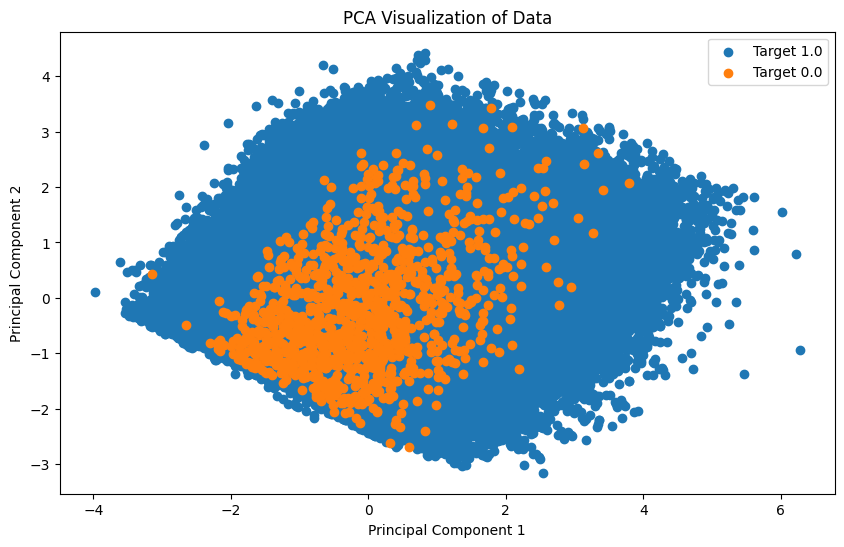

1177 185812
184635 369270

LogisticRegression with L1
Train accuracy = 0.564221301486717
Train precision = 0.5695891263138744
Train recall = 0.5256533160018415
Testing accuracy = 0.5841860465116279
Testing precision = 0.882979976442874
Testing recall = 0.597926221335992
Confusion Matrix:
 [[ 1963  1987]
 [10082 14993]]

LogisticRegression with L2
Train accuracy = 0.564221301486717
Train precision = 0.5695891263138744
Train recall = 0.5256533160018415
Testing accuracy = 0.5842204995693367
Testing precision = 0.8829868676756375
Testing recall = 0.5979661016949153
Confusion Matrix:
 [[ 1963  1987]
 [10081 14994]]


In [12]:
#remove outliers and depend on order_created time , BALANCE OverSampling

df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = False)

# remove outliers from train
train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
#check if tot_unique_items > total_order_items -> it's none
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

#CHECK
q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]


#impute
test = test.fillna(train.mean())
train = train.fillna(train.mean())
# columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
# for column in columns_to_impute:
#     mean_col = train.groupby('vendor_id')[column].transform('mean')
#     train[column].fillna(mean_col, inplace=True)
#     train[column].fillna(mean_col.mean(), inplace=True)
#     test[column].fillna(mean_col, inplace=True)
#     test[column].fillna(mean_col.mean(), inplace=True)


y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)


X_train.drop(['vendor_id'], axis = 1, inplace=True)
X_test.drop(['vendor_id'], axis = 1, inplace=True)
X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
#X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
#X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create RobustScaler instance
scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()

#balance
print(len(y_train.loc[y_train == 0]), len(y_train))
over_sampl = RandomOverSampler(random_state=0)
X_train, y_train = over_sampl.fit_resample(X_train, y_train)
print(len(y_train.loc[y_train == 0]), len(y_train))

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)


# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(X_train, y_train)

# y_pred_train = svm_classifier.predict(X_train)
# y_pred_test = svm_classifier.predict(X_test)

# confusion_mat = confusion_matrix(y_test, y_pred_test)
# print("\n SVM")
# print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
# print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
# print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
# print("Testing accuracy = {}:".format(metrics.accuracy_score(y_test, y_pred_test)))
# print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
# print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
# print("Confusion Matrix:\n", confusion_mat)

0


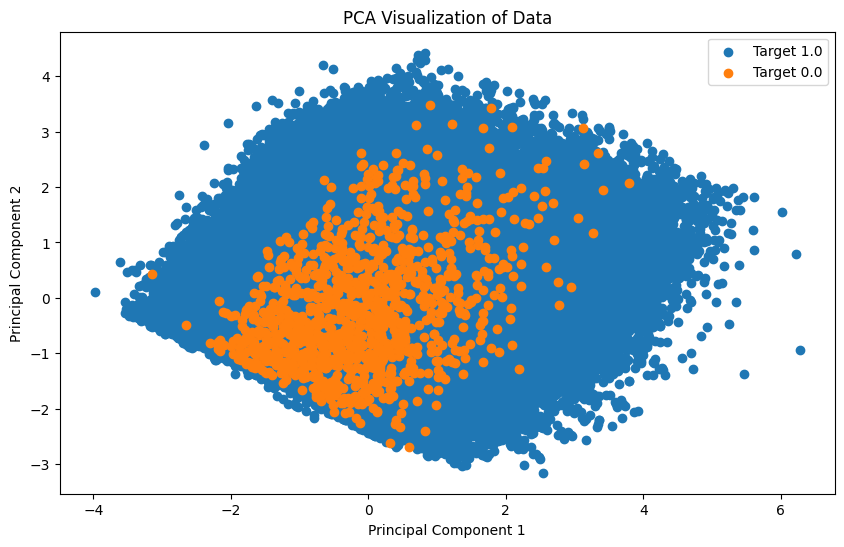

1177 185812
184635 369270

LogisticRegression with L1
Train accuracy = 0.5401034473420533
Train precision = 0.5448656967831456
Train recall = 0.4870311696048961
Testing accuracy = 0.5734711455641688
Testing precision = 0.8906394239645516
Testing recall = 0.5771485543369891
Confusion Matrix:
 [[ 2173  1777]
 [10603 14472]]

LogisticRegression with L2
Train accuracy = 0.5401061553876567
Train precision = 0.5448684545377428
Train recall = 0.48703658569610314
Testing accuracy = 0.5734711455641688
Testing precision = 0.8906394239645516
Testing recall = 0.5771485543369891
Confusion Matrix:
 [[ 2173  1777]
 [10603 14472]]


In [5]:
df = pd.read_json('order_cancellation_data.json')

df.sort_values(by=['order_create_time'])
df.drop(['order_create_time'], axis = 1, inplace=True)

df.loc[df['payment_type'].isna(), 'payment_type'] = 'Other'
print(df['payment_type'].isna().sum()) 

label_encoder = LabelEncoder()
df['order_status'] = label_encoder.fit_transform(df['order_status'])
df['payment_type'] = label_encoder.fit_transform(df['payment_type'])
train, test = train_test_split(df, test_size=0.1, shuffle = False)

# remove outliers from train
train = train.loc[(train['cost(USD)']) > 0]
train = train.loc[(train['total_order_items']) > 0 & (train['tot_unique_items'] > 0)]

q = train["cost(USD)"].quantile(0.95)
train = train.loc[train["cost(USD)"] <= q]
#check if tot_unique_items > total_order_items -> it's none
q = train["total_order_items"].quantile(0.95)
train = train.loc[train["total_order_items"] <= q] #remove outliers and from unique

#CHECK
q = train["estimated_delivery_time"].quantile(0.95)
train = train.loc[train["estimated_delivery_time"] <= q]
q = train["vendor_client_distance"].quantile(0.95)
train = train.loc[train["vendor_client_distance"] <= q]


#impute
test = test.fillna(train.mean())
train = train.fillna(train.mean())
# columns_to_impute = ['cost(USD)', 'estimated_delivery_time', 'vendor_client_distance', 'predicted_order_preparation_time']
# for column in columns_to_impute:
#     mean_col = train.groupby('vendor_id')[column].transform('mean')
#     train[column].fillna(mean_col, inplace=True)
#     train[column].fillna(mean_col.mean(), inplace=True)
#     test[column].fillna(mean_col, inplace=True)
#     test[column].fillna(mean_col.mean(), inplace=True)


y_train = train['order_status']
X_train = train.drop(['order_status'], axis = 1)
y_test = test['order_status']
X_test = test.drop(['order_status'], axis = 1)


X_train.drop(['vendor_id'], axis = 1, inplace=True)
X_test.drop(['vendor_id'], axis = 1, inplace=True)
X_train.drop(['tot_unique_items'], axis = 1, inplace=True)
X_test.drop(['tot_unique_items'], axis = 1, inplace=True)
#X_train.drop(['estimated_delivery_time'], axis = 1, inplace=True)
#X_test.drop(['estimated_delivery_time'], axis = 1, inplace=True)

#scaling
columns_to_scale = [name for name in X_train.columns if name != 'payment_type']

# Create RobustScaler instance
scaler = StandardScaler()
scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


#visualize with pca
n_components = 2  # Number of components for 2D visualization
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data=np.c_[X_pca, y_train], columns=[f'PC{i}' for i in range(1, n_components + 1)] + ['target'])
plt.figure(figsize=(10, 6))
for target_value in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == target_value]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Target {target_value}')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.legend()
plt.show()


#balance
print(len(y_train.loc[y_train == 0]), len(y_train))
over_sampl = RandomOverSampler(random_state=0)
X_train, y_train = over_sampl.fit_resample(X_train, y_train)
print(len(y_train.loc[y_train == 0]), len(y_train))

pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Logistic Regression with L1 regularization
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
l1_logreg.fit(X_train, y_train)
print("\nLogisticRegression with L1")
y_pred_train = l1_logreg.predict(X_train)
y_pred_test = l1_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)

# Logistic Regression with L2 regularization
l2_logreg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
l2_logreg.fit(X_train, y_train)

print("\nLogisticRegression with L2")
y_pred_train = l2_logreg.predict(X_train)
y_pred_test = l2_logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)
print('Train accuracy = {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Train precision = {}'.format(metrics.precision_score(y_train, y_pred_train)))
print('Train recall = {}'.format(metrics.recall_score(y_train, y_pred_train)))
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_test)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_mat)